# Лабораторная работа №1

#### Работу выполнил студент группы 9383, Звега Александр

## Цель работы
1) Освоить Jupyter Notebook.

2) Выполнить загрузку аудио сигнала и построить огибающую (график).

3) Фильтрация (выбрать один из 4 основных типов фильтров). Получить фильтрованный сигнал.

4) Детектор сигнал/шум. Получить сигнал после детектирования.

5) Эффект ”Эхо”. Получить сигнал после работы аудио-эффекта.

6) Бонусное задание: эффект ”Distortion”(классический вариант). Получить сигнал после работы аудио-эффекта.

## Загрузка аудиосигнала из файла

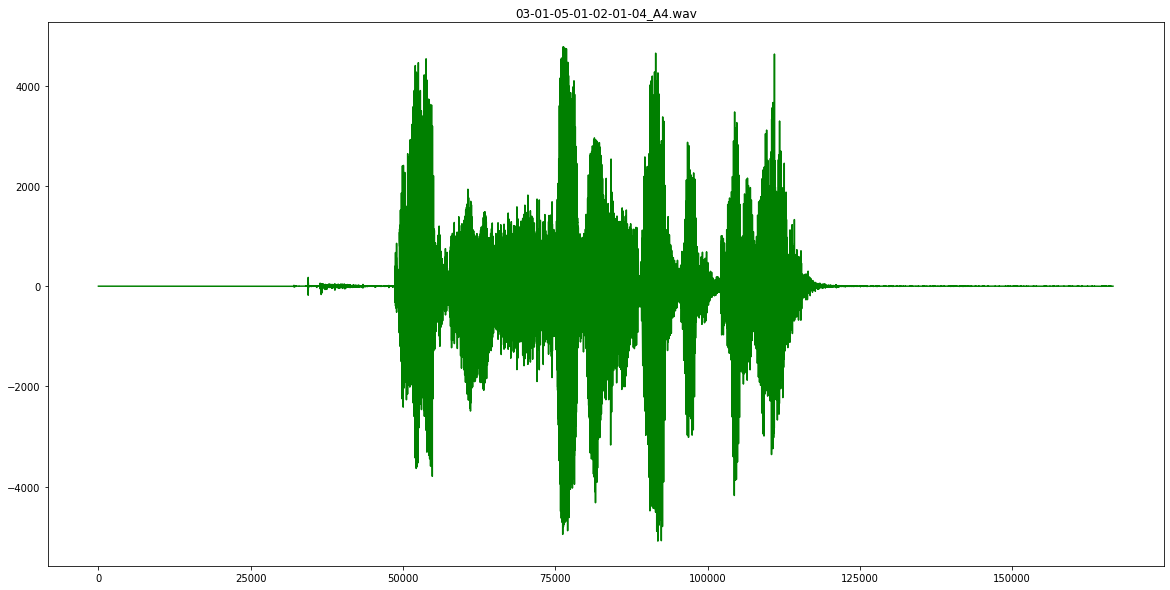

In [1]:
import wave
import matplotlib.pyplot as plt
import numpy as np
from scipy.io.wavfile import write 


def write_file(path, rate, data):
    write(path, rate, data.astype(np.int16))

def load_file(path):
    audio_file = wave.open(path)
    samples = audio_file.getnframes()
    params = audio_file.getparams()
    signal = np.frombuffer(audio_file.readframes(samples), dtype=np.int16)
    audio_file.close()  
    return (params, signal)
    
    
params, signal = load_file("03-01-05-01-02-01-04_A4.wav")
sample_rate = params[2]


plt.figure(figsize=(20, 10))
plt.title("03-01-05-01-02-01-04_A4.wav")
plt.plot(signal, color='green')
plt.show()

## Построение огибающей

Имеется сигнал $ x(i), i=0,1,...,N-1 $. Хотим построить огибающую $ y(j), j=0,1,...,n-1 $.

Пусть $ m=[\frac{N}{n}]$ - число точек в интервале усреднения. Тогда,

$y(j)=\frac{1}{m}\sum_{k=mj}^{mj+m-1} |x(k)|$

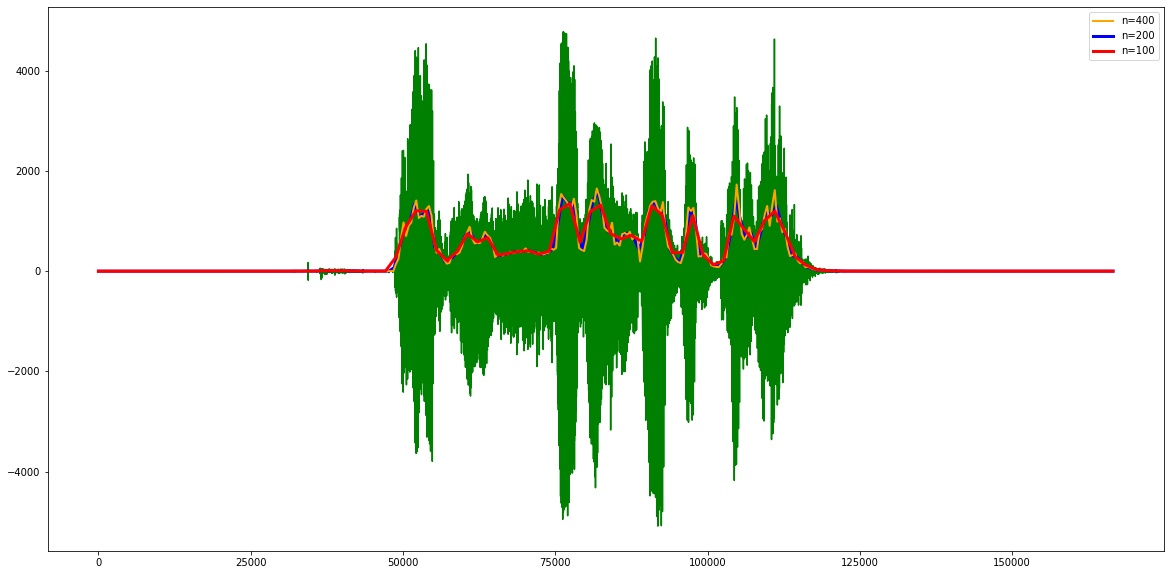

In [2]:
def curve(signal, n):
    N = len(signal)
    m = int(N/n)
    y = [np.sum(np.abs(signal[m*j : m*j+m]))/m for j in range(n)]
    return (np.linspace(start=0, stop=N, num=n), y)


x1, y1 = curve(signal, 100)
x2, y2 = curve(signal, 200)
x3, y3 = curve(signal, 400)

plt.figure(figsize=(20, 10))
plt.plot(signal, color = 'green')
plot2, = plt.plot(x2, y2, color = 'blue', linewidth = 3)
plot3, = plt.plot(x3, y3, color = 'orange', linewidth = 2)
plot1, = plt.plot(x1, y1, color = 'red', linewidth = 3)
plt.legend([plot3, plot2, plot1], ['n=400', 'n=200', 'n=100'])
plt.show()

## Фильтрация сигнала с помощью полосового фильтра

Для реализации полосового фильтра были использованы функции $ butter(m, wn, type) $ и $ filtfilt(b, a, x) $ из библиотеки $ scipy $.

Параметры фукции $ butter $:

$  m - $ порядок фильтра.

$  wn - $ частота среза. Частота среза для полосового фильтра определяется как

$ wn_{low} = 2*\frac{low}{F_{d}}$

$ wn_{high} = 2*\frac{high}{F_{d}}$где $ F_{d} $ - частота дискретизации

$  type - $ тип фильтра. В случае полосового фильтра необходимо указать $ 'bandpass' $.

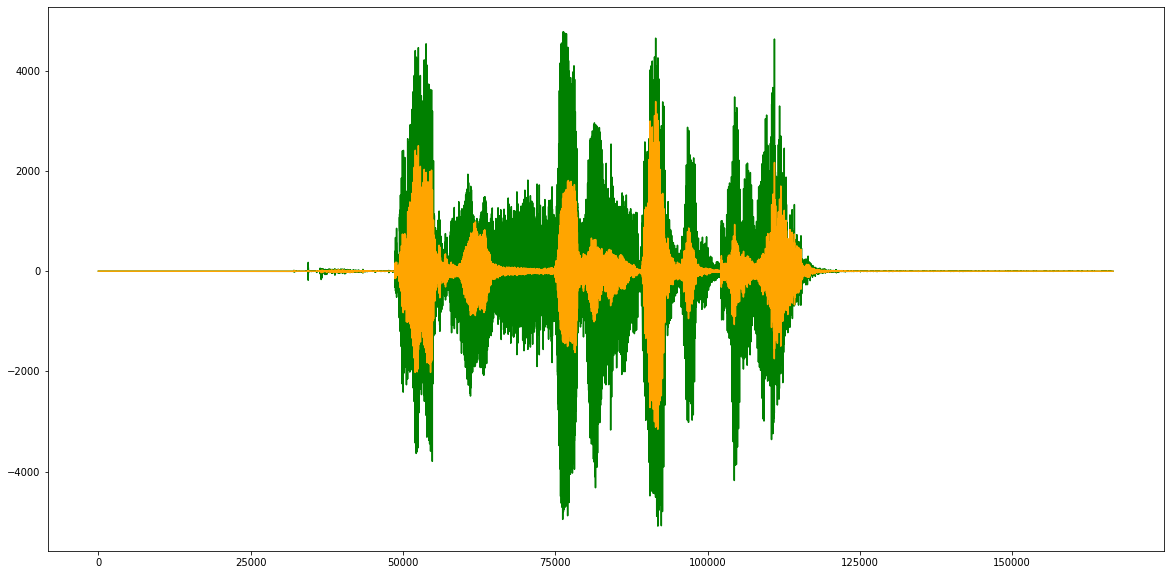

In [3]:
import scipy.signal

def filter_signal(order, low, high): 
    b, a = scipy.signal.butter(order, [2*low/sample_rate, 2*high/sample_rate], 'bandpass')
    return scipy.signal.filtfilt(b, a, signal)

z = filter_signal(order = 1, low = 1000.0, high = 3000.0)

#write_file("bandpass.wav", sample_rate, z)

plt.figure(figsize=(20, 10))
plt.plot(signal, color = 'green')
plt.plot(z, color = 'orange')
plt.show()

## Амплитудный детектор сигнал/шум

Определяем среднее сигнала по амплитуде (без учета знака):

$mid=\frac{1}{N}\sum_{k=0}^{N-1} |x(k)|$

Определяем порог детектора — $ Th = \alpha * mid $, где $ 0 \lt \alpha \lt 1 $ подбирается экспериментально.

Задаем величину ”провала”(в отсчетах) — $ k $. Обозначим $ y(i) $ — сигнал после детектирования.

Событие ”начало сигнала”. Если $ x(i) $ в течении $ k $ отсчетов превышает порог, $ y(i) = x(i) $

Событие ”окончание сигнала”. Если $ x(i) $ в течении $ k $ отсчетов меньше порога, $ y(i)=0 $

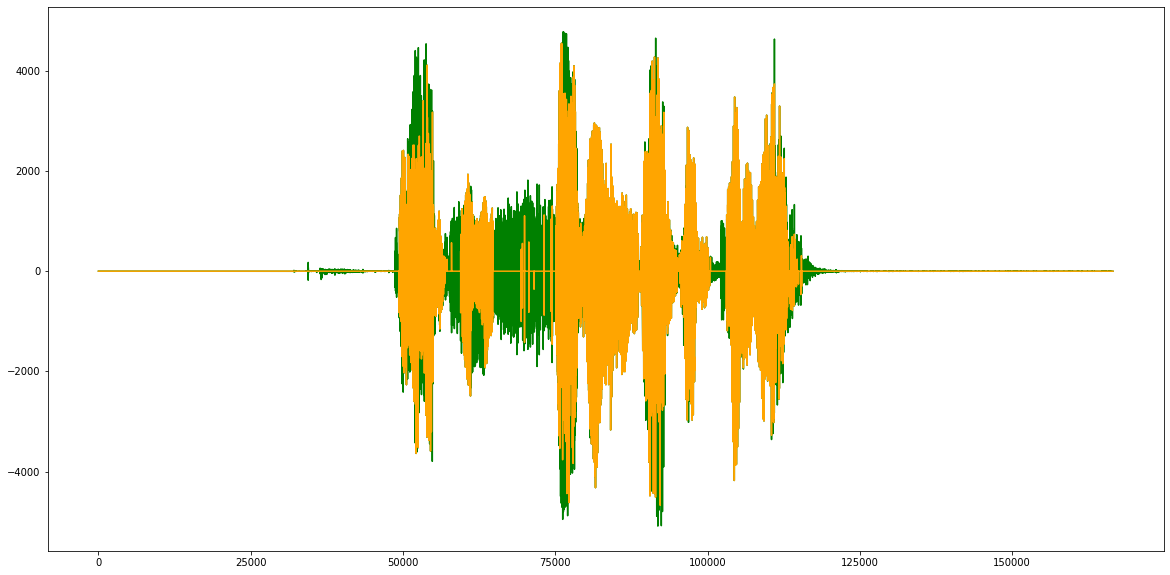

In [4]:
mid = np.sum(np.abs(signal))/len(signal)

alpha = 0.8
k = 15
threshold = alpha*mid
         
y = np.zeros(len(signal))

for i in range(len(signal)):
    subsequence = np.array(signal[i : i+k])
    if np.all(np.abs(subsequence) > threshold):
        y[i] = signal[i]

#write_file("noise.wav", sample_rate, y)        

plt.figure(figsize=(20, 10)) 
plt.plot(signal, color = 'green')
plt.plot(y, color = 'orange')
plt.show()

## Эффект "Эхо" (простейший ревербератор)

Ревербератор реализован, как набор линий задержки. Число линий задержки $ N_{L} > 8 $. Каждая линия задержки имеет свой весовой коэффициент: $  \alpha_{1} \gt \alpha_{2} \gt ... \gt \alpha_{N_{L}}  $

Перед добавлением к исходному сигналу, выход ревербератора фильтруется ФНЧ-фильтром первого порядка.

Желаемое соотношение между ”сухим” и обработанным сигналом задается коэффициентом применимости $ \gamma $.

Задержки определяются через максимальную задержку $ D_{1} $ как $  D_{i} = D_{1}^\frac{1-i}{N_{L}}, i=2,...,N_{L} $

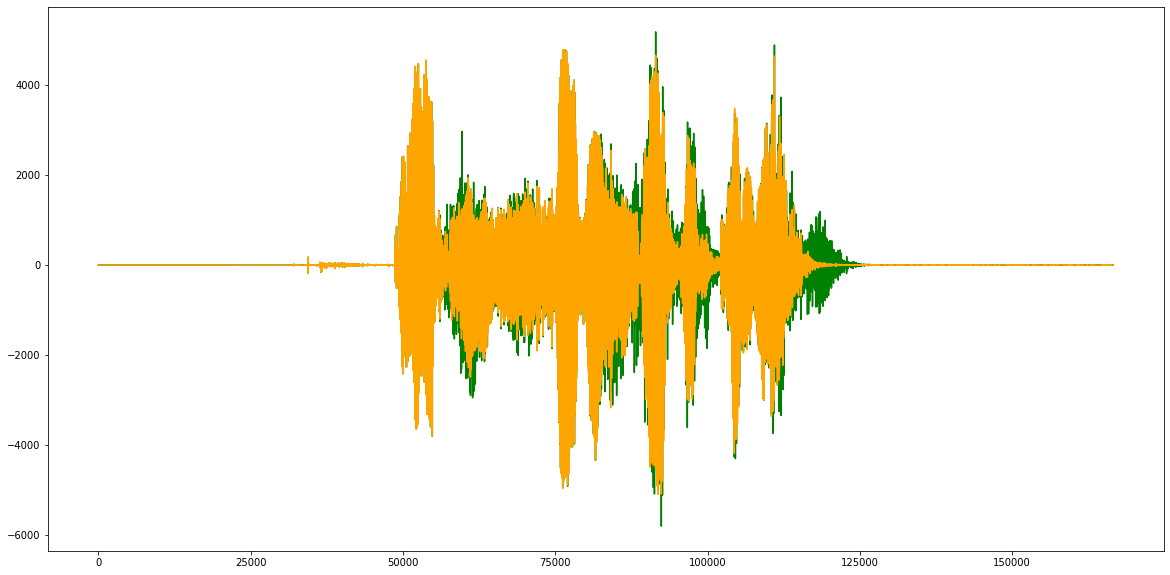

In [5]:
Nl = 15
D1 = 7500
a1 = 0.8
Ds = [int(D1*2**((1-i)/Nl)) for i in range(1, Nl+1)]
a = [a1/2**i for i in range(0, Nl)]

delayed_signal = np.zeros(len(signal))

for delay, alpha in zip(Ds, a):
    for j in range(delay, len(delayed_signal)):
        delayed_signal[j] += signal[j-delay]*alpha
   

low = 3000
b, a = scipy.signal.butter(1, 2*low/sample_rate, 'lowpass')
delayed_signal = scipy.signal.filtfilt(b, a, delayed_signal)        
        
gamma = 0.4
for i in range(len(signal)):
    delayed_signal[i] = delayed_signal[i]*gamma + signal[i]
    

#write_file("reverb.wav", sample_rate, delayed_signal)    
    
plt.figure(figsize=(20, 10)) 
plt.plot(delayed_signal, color = 'green')
plt.plot(signal, color = 'orange')
plt.show()

## Эффект "Distortion"

Обозначим входной сигнал и выходной сигналы, соответственно как $ x(i) $ и $ y(i) $, $ i = 0,1, . . . , N-1 $. Пользователь задает порог — $ threshold $ и максимальное значение сигнала $Max > threshold $. Тогда

$
Y(i) =
\begin{cases}
 x(i) ,&amp; |x(i)| \leq Th \\
 Max*sign(x(i))  ,&amp; |x(i)| \gt Th
 \end{cases}       
$

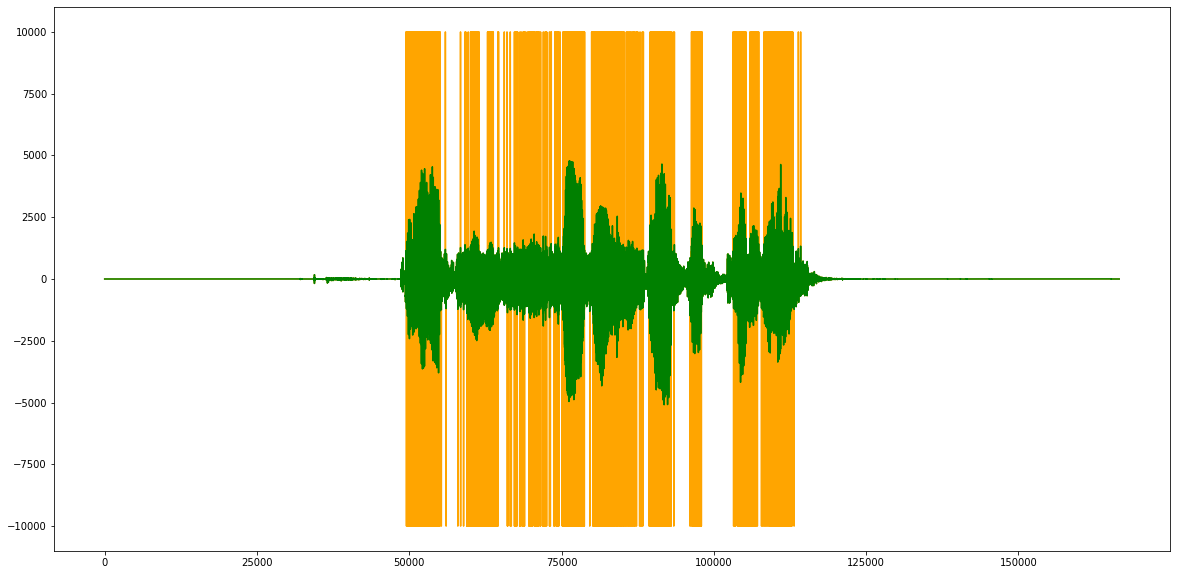

In [6]:
threshold = np.sum(np.abs(signal))/len(signal)*4
Max = 10000
   

y = []
for i in range(len(signal)):
    if abs(signal[i]) > threshold:
        y.append(np.sign(signal[i])*Max)
    else:
        y.append(signal[i])

#write_file("distortion.wav", sample_rate, np.array(y)) 
             
plt.figure(figsize=(20, 10))
plt.plot(y, color = 'orange')
plt.plot(signal, color = 'green')
plt.show()

## Выводы


При выполнении работы были изучены основы цифровой обработки сигналов с помощью библиотек Python. Для загрузки аудиосигнала и извлечения из него основных параметров использовалась библиотека wave. Для фильтрации сигнала была использована библиотека scipy. Так же в процессе выполнения работы был освоен Jupyter Notebook.